<a href="https://colab.research.google.com/github/sanghoonsim/EEE511-Artificial-Neural-Computation/blob/main/Show_and_Tell_flickr30k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download Flickr30k download
!gdown --id 1YZaKTk0slPmV1x-b432nTtlcd-s0EvkN --output Flickr30k_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1YZaKTk0slPmV1x-b432nTtlcd-s0EvkN
To: /content/Flickr30k_dataset.zip
100% 8.77G/8.77G [02:48<00:00, 52.0MB/s]


In [2]:
%%capture
!unzip Flickr30k_dataset.zip

In [3]:
!rm -rf ./flickr30k_images/flickr30k_images/flickr30k_images

In [4]:
!rm Flickr30k_dataset.zip

In [5]:
import csv

f = open('./flickr30k_images/results.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
list2 = []
for line2 in rdr:
    list2.append(line2)
f.close()
print(list2[1][0].split('|')[2])
print(len(list2))

f = open('captions.txt', 'w')
for i in range(len(list2)):
  f.write(list2[i][0].split('|')[0])
  f.write(',')
  try:
    f.write(list2[i][0].split('|')[2].lstrip())
  except:
    print(list2[i][0].split('|')[1])

  f.write('\n')

 Two young guys with shaggy hair look at their hands while hanging out in the yard .
158916
 4   A dog runs across the grass .


In [6]:
!rm ./flickr30k_images/results.csv

In [7]:
!rm ./flickr30k_images/flickr30k_images/results.csv

In [8]:
# Install library to calculate BLEU Score
!pip install torchtext==0.6.0

     |████████████████████████████████| 64 kB 1.5 MB/s 
     |████████████████████████████████| 1.2 MB 5.8 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0


In [9]:
# Resize all the images in the dataset
import os
from PIL import Image

image_dir = "./flickr30k_images/flickr30k_images" # Path to original image
train_image_dir = "./resized_train/images" # Path to resized image(Training)
val_image_dir = "./resized_val/images" # Path to resized image(Validation)
test_image_dir = "./resized_test/images" # Path to resized image(Testing)
size = [256, 256] # size of resized image


def resize_image(image, size):
    # Image,ANTIALIAS: to avoid defection when high resolution image is resized into low resolution  
    return image.resize(size, Image.ANTIALIAS) 

# Move the resized image in the image_dir to the result folder(Learning, Validation and Testing)
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # Sorting both image and caption by name
num_images = len(images)
num_train_images = 22500 # 6000 for Learning data
num_val_images = 3750 # 1000 for validation

print(len(images))
print(images[0])
print(images[-1])



31783
1000092795.jpg
998845445.jpg


In [10]:
for i, image in enumerate(images): # Distribute images into three categories by numbers
    # print(i, image) : 0 1000268201_693b08cb0e.jpg
    if (i + 1) <= num_train_images:
        output_dir = train_image_dir
    elif (i + 1) <= num_train_images + num_val_images:
        output_dir = val_image_dir
    else:
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
    if (i + 1) % 500 == 0: # print progress in every 500-th turn
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

[500/31783] Resized the images and saved into './resized_train/images'
[1000/31783] Resized the images and saved into './resized_train/images'
[1500/31783] Resized the images and saved into './resized_train/images'
[2000/31783] Resized the images and saved into './resized_train/images'
[2500/31783] Resized the images and saved into './resized_train/images'
[3000/31783] Resized the images and saved into './resized_train/images'
[3500/31783] Resized the images and saved into './resized_train/images'
[4000/31783] Resized the images and saved into './resized_train/images'
[4500/31783] Resized the images and saved into './resized_train/images'
[5000/31783] Resized the images and saved into './resized_train/images'
[5500/31783] Resized the images and saved into './resized_train/images'
[6000/31783] Resized the images and saved into './resized_train/images'
[6500/31783] Resized the images and saved into './resized_train/images'
[7000/31783] Resized the images and saved into './resized_train/i

In [11]:
# Build vocabs using captions
import pickle # To store the object as binary
import nltk # For natural language processing
from collections import Counter

nltk.download('punkt') # Download tokenizer

caption_path = "./captions.txt" # Path to captions.txt
vocab_path = "./vocab.pkl" # vocabs
word_threshold = 4 # the minumum nuber of appearance
train_caption_path = "./resized_train/captions.txt" # Path to captions of resized image(Training)
val_caption_path = "./resized_val/captions.txt" # Path to captions of resized image(Validation)
test_caption_path = "./resized_test/captions.txt" # Path to captions of resized image(Testing)


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        # If unable to figure out the word
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        # If there is a word for captioning    
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

counter = Counter()

with open(caption_path, "r") as f: # Read captions.txt
    lines = sorted(f.readlines()[1:]) # 0-th line is a headlines
    for i in range(len(lines)):
        line = lines[i]
        if (i + 1) <= num_train_images * 5: # Becuase there are 5 captions per 1 image
            output_caption = train_caption_path
        elif (i + 1) <= (num_train_images + num_val_images) * 5:
            output_caption = val_caption_path
        else:
            output_caption = test_caption_path
        index = line.find(",") # Find the starting point of caption. [name of image, caption]
        caption = line[index + 1:] # Recording character of captions
        # tokens ['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.']
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        # Counter({'a': 3, 'in': 2, 'child': 1, 'pink': 1, 'dress': 1, 'is': 1, 
        #          'climbing': 1, 'up': 1, 'set': 1, 'of': 1, 'stairs': 1, 'an': 1, 'entry': 1, 'way': 1, '.': 1})
        counter.update(tokens) # dictionary
        with open(output_caption, "a") as output_caption_f: # save the in the path (train_caption_path, val_caption_path or test_caption_path)
            output_caption_f.write(line)
# only if when it surpass the threshold
words = [word for word, cnt in counter.items() if cnt >= word_threshold] # make a list composed of words that appears over the number threshold
# 'word'      'cnt'
# david         2
# beckham       1
# canvasses     1
# enforcment  1
# ...
vocab = Vocabulary() # add the word, then the two lists are implemented, 'word2idx' and 'idx2word'
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>') # when object is unknown

# assign all the words to Vocabulary object
for word in words:
    vocab.add_word(word)

# Save them in "./vocab.pkl"
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f) # usage of pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
# The number of captions(Training) in dataset
!wc -l ./resized_train/captions.txt
# The number of captions(Val) in dataset
!wc -l ./resized_val/captions.txt
# The number of captions(Testing) in dataset
!wc -l ./resized_test/captions.txt

112500 ./resized_train/captions.txt
18750 ./resized_val/captions.txt
27665 ./resized_test/captions.txt


In [13]:
# Define Flickr8kDataset Class
import torch.utils.data as data

class Flickr8kDataset(data.Dataset): # Define Flickr8k Dataset
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # Path to image
        with open(captions, "r") as f:
             lines = f.readlines()
             self.captions = [] # list to store the captions
             for line in lines: 
                index = line.find(",") # find the starting point of the caption
                path = line[:index] # name of image file
                caption = line[index + 1:] # the content of the caption
                self.captions.append((path, caption))
        self.vocab = vocab
        self.transform = transform

    # retrieve the image and caption one by one
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0] # the name of the image
        caption = self.captions[index][1] # the caption

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Tokenize the caption
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>')) # Start tag
        caption.extend([vocab(token) for token in tokens]) # Pick words in vocabs if word is in token
        caption.append(vocab('<end>')) # End tag
        target = torch.Tensor(caption) # Create a tensor
        return image, target

    def __len__(self):
        return len(self.captions)

In [14]:
# Batch the tuple composed of a image and a caption
def collate_fn(data):
    """
    [Input]
    * data : list of tuple (image, caption)
      * image : torch tensor of shape (3, 256, 256)
      * caption : torch tensor of shape (?); variable length
    [output]
    * images : torch tensor of shape (batch_size, 3, 256, 256)
    * targets: torch tensor of shape (batch_size, padded_length)
    * lengths: list; valid length for each padded caption
    """
    # Sort data by the length of the captions
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images in the form of the list into one tensor (num of data, 3, 256, 256)
    images = torch.stack(images, 0)

    # Merge captions in the form of the list into one tensor(num of data, the number of tokens in the largest length of the token)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # get rid of padding
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def collate_fn_test(data):
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader # images, captions, lengths for each iteration

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, images):
        with torch.no_grad(): 
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) 
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed) 
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):

        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

In [16]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/" 
crop_size = 224 
vocab_path = "./vocab.pkl" 

if not os.path.exists(model_path):
    os.makedirs(model_path)

with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [17]:
# Define model's hyper parameter
embed_size = 256 
hidden_size = 512 
num_layers = 1 

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 5
learning_rate = 0.001

log_step = 20 
save_step = 1000 #

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [20]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

image_path = "./resized_test/images/5264507624.jpg" 
encoder_path = "./models/encoder-5.ckpt" # path for trained encoder
decoder_path = "./models/decoder-5.ckpt" # path for trained decoder
vocab_path = "./vocab.pkl" # path for vocabulary wrapper

# Model parameters (should be same as paramters in train.py)
embed_size = 256 # dimension of word embedding vectors
hidden_size = 512 # dimension of lstm hidden states
num_layers = 1 # number of layers in lstm

In [22]:
# image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval() # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image = load_image(image_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids: 
    word = vocab.idx2word[word_id] 
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

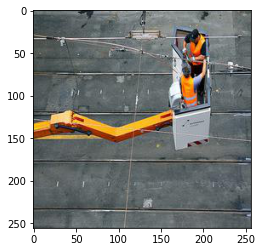

<start> a man in a yellow shirt is standing on a ladder . <end>


In [23]:
import matplotlib.pyplot as plt
import numpy as np
image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print(sentence)

In [24]:
predictions = []
answers = []
answers_per_image = []

total_step = len(test_data_loader)
cnt = 0

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(test_data_loader):
        images = images.to(device)
        captions = captions.to(device)

        # 순전파(forward) 진행
        features = encoder(images)
        sampled_ids_list = decoder.sample(features)

        for index in range(len(images)):
            sampled_ids = sampled_ids_list[index].cpu().numpy()

            # 정답 문장(answer sentences)
            answer = []
            for word_id in captions[index]: # 하나씩 단어 인덱스를 확인하며
                word = vocab.idx2word[word_id.item()] # 단어 문자열로 바꾸어 삽입
                answer.append(word)
                if word == '<end>':
                    break
            answers_per_image.append(answer[1:-1]) # 정답 문장을 삽입 (<sos>과 <eos>는 제외)

            if (cnt + 1) % 5 == 0: # 이미지당 캡션이 5개씩 존재
                answers.append(answers_per_image) # 5개를 한꺼번에 리스트로 삽입
                answers_per_image = []

                # 예측한 문장(predicted sentences)
                prediction = []
                for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
                    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
                    prediction.append(word)
                    if word == '<end>':
                        break
                predictions.append(prediction[1:-1]) # 예측한 문장에 대해서는 1개만 삽입 (<sos>과 <eos>는 제외)
            cnt += 1

        if i % log_step == 0:
            print(f"[ Testing ] Batch size: {i}/{total_step}")

[ Testing ] Batch size: 0/217
[ Testing ] Batch size: 20/217
[ Testing ] Batch size: 40/217
[ Testing ] Batch size: 60/217
[ Testing ] Batch size: 80/217
[ Testing ] Batch size: 100/217
[ Testing ] Batch size: 120/217
[ Testing ] Batch size: 140/217
[ Testing ] Batch size: 160/217
[ Testing ] Batch size: 180/217
[ Testing ] Batch size: 200/217


In [25]:
print("예측한 문장의 수:", len(predictions))
print("정답 문장 집합의 수 (5개씩):", len(answers))

예측한 문장의 수: 5533
정답 문장 집합의 수 (5개씩): 5533


In [26]:
index = 2
print("[ 정답 캡션들 ]")
for answer in answers[index]:
    print(answer)

print("[ 예측된 캡션 ]")
print(predictions[index])

[ 정답 캡션들 ]
['a', '<unk>', 'car', 'with', 'many', 'firefighters', 'cutting', 'into', 'the', 'car', '.']
['emergency', 'personnel', 'work', 'at', 'the', 'scene', 'of', 'major', 'car', 'accident', 'between', 'a', 'car', 'and', 'a', 'pick-up', 'truck', '.']
['firefighters', 'are', 'at', 'the', 'scene', 'of', 'a', 'car', 'accident', 'involving', 'two', 'vehicles']
['firemen', 'clean', 'up', 'the', 'scene', 'of', 'a', 'major', 'motor', 'vehicle', 'accident']
['two', 'cars', 'got', 'into', 'a', 'bad', 'accident', '.']
[ 예측된 캡션 ]
['a', 'group', 'of', 'construction', 'workers', 'are', 'working', 'on', 'a', 'railroad', 'track', '.']


In [27]:
from torchtext.data.metrics import bleu_score

bleu = bleu_score(predictions, answers, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
print(f'Total BLEU Score = {bleu * 100:.2f}')

individual_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
individual_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[0, 1, 0, 0])
individual_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 1, 0])
individual_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 0, 1])

print(f'Individual BLEU1 score = {individual_bleu1_score * 100:.2f}') 
print(f'Individual BLEU2 score = {individual_bleu2_score * 100:.2f}') 
print(f'Individual BLEU3 score = {individual_bleu3_score * 100:.2f}') 
print(f'Individual BLEU4 score = {individual_bleu4_score * 100:.2f}') 

cumulative_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
cumulative_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[1/2, 1/2, 0, 0])
cumulative_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[1/3, 1/3, 1/3, 0])
cumulative_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

print(f'Cumulative BLEU1 score = {cumulative_bleu1_score * 100:.2f}') 
print(f'Cumulative BLEU2 score = {cumulative_bleu2_score * 100:.2f}') 
print(f'Cumulative BLEU3 score = {cumulative_bleu3_score * 100:.2f}') 
print(f'Cumulative BLEU4 score = {cumulative_bleu4_score * 100:.2f}')

Total BLEU Score = 14.12
Individual BLEU1 score = 57.63
Individual BLEU2 score = 22.01
Individual BLEU3 score = 8.65
Individual BLEU4 score = 3.63
Cumulative BLEU1 score = 57.63
Cumulative BLEU2 score = 35.62
Cumulative BLEU3 score = 22.22
Cumulative BLEU4 score = 14.12
